# Mandatory Assignment 2

This is the last of three mandatory assignments which must be completed during the course. Note that you only need to pass 2 out of 3 assignments to be eligible for the exam.


First some practical information:

* When is the assignment due?: **23:59, Friday, August 13, 2020.**
* Should i work with my group?: **Yes**. In particular, you should **only hand in 1 assignment per group**.

The assignment consists of problems from some of the exercise sets that you have solved so far.

**Note**: It is important that you submit your edited version of THIS [notebook](https://fileinfo.com/extension/ipynb#:~:text=An%20IPYNB%20file%20is%20a,Python%20language%20and%20their%20data.) as a .ipynb file and nothing else. 

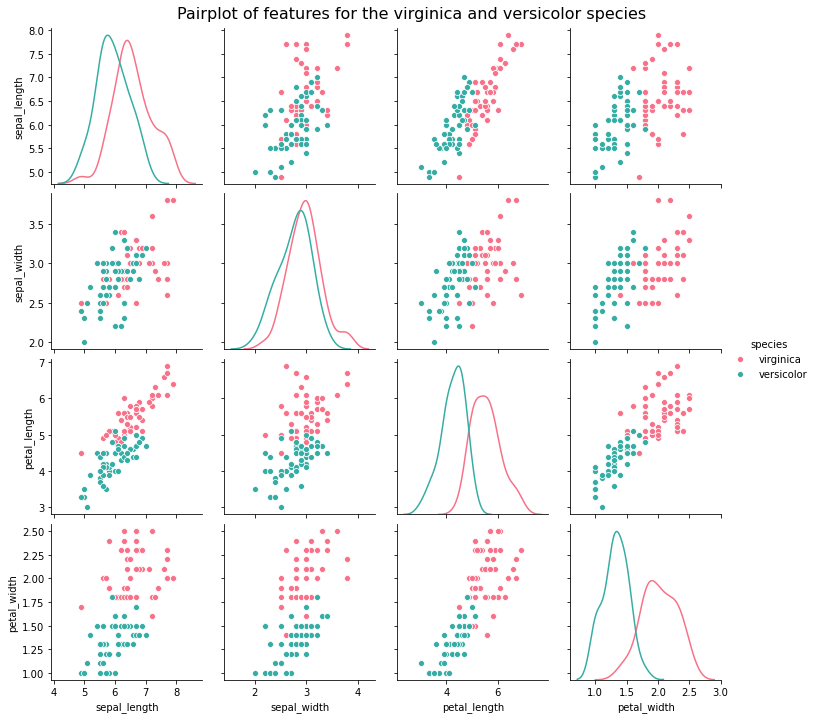

In [12]:
############################################################
#RUN THIS CELL AND USE THE DATA TO SOLVE THE NEXT EXERCISES#
############################################################
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

iris = sns.load_dataset('iris')
iris = iris.query("species == 'virginica' | species == 'versicolor'").sample(frac = 1, random_state = 3)
X = np.array(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
y = np.array(iris['species'].map({'virginica': 1, 'versicolor': -1}))

# EDA before modelling 
# Do the two species look perfectly linear seperable in any of the plots? 
ax = sns.pairplot(iris, hue="species", palette="husl", diag_kws = {'shade': False})
ax.fig.subplots_adjust(top=0.95)
ax.fig.suptitle('Pairplot of features for the virginica and versicolor species', fontsize=16)

plt.show()

# A very simple deterministic test-train split 
X_train = X[:70]
y_train = y[:70]

X_test = X[70:]
y_test = y[70:]

## Problems from Exercise Set 10:

> **Ex. 10.1.5:** Write a function named `perceptronEpoch` whichs loops over the training data (both X and y) using `zip`. For each row in the data, update the weights according to the perceptron rule (remember to update the bias in `w[0]`!). Set $\eta = 0.1$.
>
> Make sure the loop stores the total number of prediction errors encountered underways in the loop by creating an `int` which is incremented whenever you update the weights. 
>
>> _Hint:_ your function should return the updated weights, as well as the number of errors made by the perceptron.
>
>> _Hint:_ The following code block implements the function in _pseudo_code (it wont run, but serves to communicate the functionality).
>> ```
>> function perceptronEpoch(X, y, W, eta):
>>    set errors = 0
>>
>>    for each pair xi, yi in zip(X,y) do:
>>        set update = eta * (yi - predict(xi, W))
>>        set W[1:] = W[1:] + update * xi
>>        set W[0] = W[0] + update
>>        set errors = errors + int(update != 0) 
>>
>>    return W, errors
>> ```
>
> *Bonus:* If you completed the previous bonus exercise (for 10.1.4), calculate the accuracy on training data using the updated weights as input in the predict function. Any progress yet?


You can use the following functions:

```python
def random_weights(location = 0.0, scale = 0.01, seed = 1):
    # Init random number generator
    rgen = np.random.RandomState(seed)
    w = rgen.normal(loc=location, scale=scale, size= 1 + X.shape[1])
    
    return w

def net_input(X, W): 
    return np.dot(X, W[1:]) + W[0]   # Linear product X'W + bias


def predict(X, W):
    linProd = net_input(X, W)
    return np.where(linProd >= 0.0, 1, -1)    # 1(linProd > 0)
```

>
> Make sure your `perceptronEpoch` function takes the arguments `X, y, W, eta`.

In [13]:
def random_weights(location = 0.0, scale = 0.01, seed = 1):
    # Init random number generator
    rgen = np.random.RandomState(seed)
    w = rgen.normal(loc=location, scale=scale, size= 1 + X.shape[1])

    return w

def net_input(X, W): 
    return np.dot(X, W[1:]) + W[0]   # Linear product X'W + bias


def predict(X, W):
    linProd = net_input(X, W)
    return np.where(linProd >= 0.0, 1, -1)    # 1(linProd > 0)

In [14]:
def perceptronEpoch(X, y, W, eta = 0.1):
    errors = 0
    
    for xi, yi in zip(X,y):
        update = eta*(yi - predict(xi, W))
        W[0] += update
        W[1:] += update*xi
        errors += int(update != 0)
    
    return W, errors

In [15]:
w, e = perceptronEpoch(Xtrain, ytrain, random_weights(), 0.1)
assert len(w) == 5
assert isinstance(e, int)

> **Ex. 10.1.6:** Write a function named `Perceptron` which repeat the updating procedure (calls the function) you constructed in 10.1.5 for `n_iter` times by packing the whole thing in a loop. Make sure you store the number of errors in each iteration in a list. 
>
> Plot the total errors after each iteration in a graph with the number of epochs along the x-axis and errors along the y-axis.
>
>> _Hint:_ Make sure you dont reset the weights after each iteration.
>
>> _Hint:_ Once again some pseudocode:
>> ```
>> function Perceptron(X, y, n_iter):
>>     set eta = 0.1
>>     set weights = random_weights()
>>     set errorseq = list()
>>
>>     for each _ in range(n_iter):
>>         weights, e = f(X, y, W, eta) 
>>         errorseq.append(e)
>>
>>     return weights, errorseq
>> ```

Please make sure that your function is named `Perceptron` and takes the arguments `X, y, n_iter, eta`


In [16]:
def Perceptron(X, y, n_iter, eta = 0.1):
    W = random_weights()
    errorseq = []
    for i in range(n_iter):
        W , error_i = perceptronEpoch(X, y, W, eta)
        errorseq.append(error_i)
    return W, errorseq

In [17]:
trained_w, errorseq = Perceptron(Xtrain, ytrain, 50, 0.1)
assert len(trained_w) == 5
assert len(errorseq) == 50
assert all(isinstance(i, int) for i in errorseq)

## Problems from Exercise Set 11:

### First part of Exercise Set 11: Implementing and evaluating the gradient decent for linear regression

In [18]:
############################################################
#RUN THIS CELL AND USE THE DATA TO SOLVE THE NEXT EXERCISES#
############################################################
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.exceptions import DataConversionWarning; import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Load the example tips dataset
tips = sns.load_dataset("tips")

#Get dummies 
tips_num = pd.get_dummies(tips, drop_first=True)

#Define feature matrix X and target vector y 
X = tips_num.drop('tip', axis = 1)
y = tips_num['tip']


#NOTE: It is important that the random_state parameter is set equal to 1
# to ensure that the same sequence of random numbers are generated as in the solution notebook
# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.5,
                                                    random_state=1)

# Standardize data - note that we only fit the standard scaler on X_train and use it on X_train, X_test. 
norm_scaler = StandardScaler().fit(X_train) 
X_train = norm_scaler.transform(X_train) 
X_test = norm_scaler.transform(X_test) 

> **Ex. 11.1.5**: Make a function to update the weights given input target `y`, input features `X` and input weights `w` as well as learning rate, $\eta$, i.e. greek `eta`. Name the function `update_weight`. You should use matrix multiplication.


You can use the following functions inside `update_weight`:

```python
def net_input(X, w):    
    ''' Computes the matrix product between X and w. Note that
    X is assumed not to contain a bias/intercept column.'''
    return np.dot(X, w[1:]) + w[0]   # We have to add w_[0] separately because this is the constant term.
                                        # We could also have added a constant term (columns of 1's to X_ and multipliced it to all of w_)

def compute_error(y, X, w):
    return y - net_input(X, w)
    
```

>
> Make sure your function takes the arguments `X, y, W, eta`.

In [19]:
def net_input(X, w):
    return np.dot(X, w[1:]) + w[0]

def compute_error(y, X, w):
    return y - net_input(X, w)

In [20]:
def update_weight(X, y, W, eta = 0.001):
    error = compute_error(y, X, W)
    W[0] += eta*error.sum()
    W[1:] += eta*X.T.dot(error)
    return W

> **Ex. 11.1.6**: Use the code below to initialize the weights in the variable `w` at zero given feature set `X`. Notice how we include an extra weight that includes the bias term. Set the learning rate `eta` to 0.001. Make a loop with 50 iterations where you iteratively apply your weight updating function. 

>```python
w = np.zeros(1+X.shape[1])
```

In [21]:
w = np.zeros(1+X.shape[1])
for i in range(50):
    update_weight(X_train, y_train, w, eta=0.001)

In [22]:
assert round(np.sum(w)) == 4
assert any(np.round(w, 2) == [ 2.93,  0.89,  0.1 ,  0.07,  0.08,  0.05,  0.  , -0.04, -0.02])

### Third part of Exercise Set 11: Modelling houseprices
In this example we will try to predict houseprices using a lot of variable (or features as they are called in Machine Learning). We are going to work with Kaggle's dataset on house prices, see information [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques), which also is to be found in `sklearn.datasets`. Kaggle is an organization that hosts competitions in building predictive models.

In [23]:
############################################################
#RUN THIS CELL AND USE THE DATA TO SOLVE THE NEXT EXERCISES#
############################################################
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

cal_house = fetch_california_housing()    
X = pd.DataFrame(data=cal_house['data'], 
                 columns=cal_house['feature_names'])\
             .iloc[:,:-2]
y = cal_house['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=1) # note random_state=1 

> **Ex.11.3.1**: Generate interactions between all features to third degree, make sure you **exclude** the bias/intercept term. How many variables are there? Will OLS fail? Write 2 sentences. 
>
> After making interactions rescale the features to have zero mean, unit std. deviation. Should you use the distribution of the training data to rescale the test data?  Write 1 sentence. 
>
>> *Hint 1*: Try importing `PolynomialFeatures` from `sklearn.preprocessing`
>
>> *Hint 2*: If in doubt about which distribution to scale, you may read [this post](https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i).

Name you transformed training data set `X_train2` and your test data set `X_test2`

In [28]:
# YOUR CODE HERE

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

pol_trans = PolynomialFeatures(degree=3, include_bias=False)
scaler = StandardScaler()

X_train2 = pol_trans.fit_transform(X_train)
X_train2 = scaler.fit_transform(X_train)

X_test2 = pol_trans.transform(X_test)
X_test2 = scaler.transform(X_test)



In [25]:
assert round(X_train2.mean(axis=0).sum()) == 0
assert round(np.std(X_train2, axis=0).sum()) == 83

AssertionError: 

> **Ex.11.3.2**: Construct a list of 20 $\lambda$ values in the range from $10^{-4}$ to $10^4$ to be used in the Lasso model. For each $\lambda$ estimate the Lasso model on the rescaled train data, calculate the _Root Mean_ Squared Error (RMSE) for the rescaled train data, `X_train2`, and the _Root Mean_ Squared Error (RMSE) for the rescaled test data, `X_test2`. For each iteration store the given $\lambda$ and the calculated RMSEs for the rescaled train and test data in a list named `output`. 

> *Hint*: use `np.logspace(-4, 4, 20)` to create the list of lambdas to loop. 

> *Hint*: You can use the following code from scikit-learn to compute the _mean_ squared error.
```python
from sklearn.metrics import mean_squared_error as mse
mse(y_pred, y_true)
```

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert any(np.sort(np.round(np.mean(output, axis=0))) == [1.0, 2.0, 806.0])

> **Ex.11.3.3**: Make a plot with the lambdas on the x-axis and the RMSE measures on the y-axis. What happens to RMSE for train and test data as $\lambda$ increases? The x-axis should be log scaled. Which one are we interested in minimizing? 

> Bonus: Can you find the lambda that gives the lowest MSE-test score?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Problems from Exercise Set 12:

> **Ex. 12.2.3:**
Run a Lasso regression using the Pipeline from `Ex 12.2.2` which is given in the code cell below. In the outer loop searching through the 12 lambda values as specified below. 
In the inner loop make *5 fold cross validation* on the selected model and store the average MSE for each fold. Which lambda, from the selection below, gives the lowest test MSE?
 ```python 
lambdas =  np.logspace(-4, 4, 12)
```
 *Hint:* `KFold` in `sklearn.model_selection` may be useful.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso

#Pipeline from Ex. 12.2.2
pipe_lasso = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),                           
                           StandardScaler(),
                           Lasso(random_state=1))

#The feature matrix X and target vector y are defined 
# as below the code cell "Second part of Exercise Set 11: Modelling houseprices". 

#Split X, y into development (2/3) and test data (1/3).
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)    

lambdas =  np.logspace(-4, 4, 12)

# YOUR CODE HERE
raise NotImplementedError()

## Problems from Session 14:

> **Ex. 1**: Make a preprocessing function that takes a single string and:

        1. Lowercases the words.
        2. Splits the text into words (tokenize).
        3. Either stems or lemmatizes words.
 
>Feel free to add more steps of preprocessing. For example stopword removal or removal of what seems to be HTML elements (such as "< br/>") in the text, and removal of punctuation, and handling of emoticons as in the textbook.

> Apply the function to the string `movie_review_sample` in the code cell below. Print the processed string. 


In [ ]:
import string # for efficient operations with strings
import nltk # NLTK: A basic, popular NLP package. 
nltk.download('punkt') 
nltk.download('wordnet') 

#example string to apply your function on 
movie_review_sample = "Forbidden Siren is based upon the Siren 2 Playstation 2 (so many 2s) game. Like most video game turned movies, I would say the majority don't translate into a different medium really well. And that goes for this one too, painfully.<br /><br />There's a pretty long prologue which explains and sets the premise for the story, and the mysterious island on which a writer (Leo Morimoto) and his children, daughter Yuki (Yui Ichikawa) and son Hideo (Jun Nishiyama) come to move into. The villagers don't look all too friendly, and soon enough, sound advice is given about the siren on the island, to stay indoors once the siren starts wailing.<br /><br />Naturally and slowly, things start to go bump, and our siblings go on a mission beating around the bush to discover exactly what is happening on this unfriendly island with its strange inhabitants. But in truth, you will not bother with what's going on, as folklore and fairy tales get thrown in to convolute the plot even more. What was really pushing it into the realm of bad comedy are its unwittingly ill-placed-out-of-the-norm moments which just drew pitiful giggles at its sheer stupidity, until it's explained much later. It's one thing trying to come up and present something smart, but another thing doing it convincingly and with loopholes covered.<br /><br />Despite it clocking in under 90 minutes - I think it's a horror movie phenomenon to have that as a runtime benchmark - it gives that almost two hour feel with its slow buildup to tell what it wants to. Things begin to pick up toward the last 20 minutes, but it's a classic case of too little too late.<br /><br />What saves the movie is how it changes tack and its revelation at the end. Again this is a common device used to try and elevate a seemingly simple horror movie into something a little bit extra in the hope of wowing an audience. It turned out rather satisfactorily, but leaves a bad aftertaste as you'll feel cheated somewhat. There are two ways a twist will make you feel - it either elevates the movie to a memorable level, or provides you with that hokey feeling. Unfortunately Forbidden Siren belonged more to the latter.<br /><br />The saving grace will be its cinematography with its use of light, shadows and mirrors, but I will be that explicit - it's still not worth the time, so better to avoid this."

# YOUR CODE HERE
raise NotImplementedError()